# Notes on sampling

Dominika Tkaczyk

4.09.2018

This notebook contains some basic experiments related to data sampling. The main purpose of this is to convince myself (and hopefully wider audience) that we can safely calculate things on samples of the data rather than on all the data.

## TL;DR

  * Sampling is a standard way of estimating the average value of a certain feature by calculating it only for a random sample, not for the entire population of items. Note that estimating =/= guessing.
  * Confidence intervals provide a way of controling the amount of uncertainty related to randomness in sampling. Confidence interval is calculated from a sample and has a form (estimated value - something, estimated value + something). An important parameter is confidence level, which we use to specify how certain we want to be about our interval.
  * Confidence interval at level 95% is interpreted as follows: we are 95% sure that the real value that we are estimating is within our calculated confidence interval.
  * The higher the confidence level (i.e. the more certain we want to be about the interval), the wider the interval has to be.
  * The larger the sample, the narrower the confidence interval.
  * We are never sure that the value we are estimating is actually within our calculated confidence interval. By setting the confidence level high, we just make sure this is an unlikely event.

## Introduction

First let's define some basic terms:
  * **population** - this is the complete set of "items" or "things" we are interested in. In statistics this is often a group of people (hence the term), for example the entire population of USA. In my experiments, the population is the entire set of metadata records (works) in Crossref system (100M records).
  * **sample** - a subset of items randomly chosen from the population. Its most important parameter is the size.
  * **statistic** - a numeric feature of the item. Examples: the age of a person, the number of authors listed in the metadata record, the length of the title.
  * **population average** - the average value of a statistic in the population.
  * **sample average** - the average value of a statistic in the sample.

In these experiments, we want to know the population average of a certain statistic. Depending on the size of the population, and how difficult it is to calculate the statistic, calculating the population average directly might not be fast enough or even possible. In such cases, one alternative is to use sampling to estimate the population average. Note that estimating =/= guessing.

Let's import some stuff.

In [1]:
import sys
sys.path.append('..')

from crossref.restful import Works, Etiquette
from multiprocessing import Pool
from statistics import mean, stdev
from utils.cr_utils import get_sample

import json
import math
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import re
import scipy.stats as st
import tarfile

I will also politely introduce myself to Crossref API.

In [2]:
works = Works(etiquette=Etiquette('Dominika\'s experiments', '0.1', '', 'dtkaczyk@crossref.org'))

## Estimating the average number of references

I chose a very simple statistic to play with: the number of references, as reported by *references-count* field in the metadata record. Later, I will do some additional experiments with a more complicated statistic.

In [3]:
def ref_count(work):
    return work['references-count']

### The exact number

The average number of references over the entire population can be, of course, calculated directly. It takes about 3 hours to iterate over the entire dataset (without parallel processing). This code needs access to snapshot of the data:

In [4]:
def iterate_files(filename):
    tar = tarfile.open(filename, 'r:gz')
    for member in tar:
        f = tar.extractfile(member)
        if f is not None:
            yield json.load(f)

def iterate_items(filename):
    for f in iterate_files(filename):
        for item in f['items']:
            yield item

records = 1e8
count = 0
total = 0
for item in iterate_items('/srv/data/snapshots/data-2018-08.tar.gz'):
    total = total + ref_count(item)
    count = count + 1
    if count % 1e4 == 0:
        print('{}% done (average ref count so far {:.4f})'.format(100*count/records, total/count))

0.01% done (average ref count so far 0.0031)
0.02% done (average ref count so far 0.0015)
0.03% done (average ref count so far 0.0010)
0.04% done (average ref count so far 0.0008)
0.05% done (average ref count so far 0.0006)
0.06% done (average ref count so far 0.0006)
0.07% done (average ref count so far 0.0005)
0.08% done (average ref count so far 0.0004)
0.09% done (average ref count so far 0.0004)
0.1% done (average ref count so far 0.0003)
0.11% done (average ref count so far 0.0003)
0.12% done (average ref count so far 0.0003)
0.13% done (average ref count so far 0.0003)
0.14% done (average ref count so far 0.0002)
0.15% done (average ref count so far 0.0002)
0.16% done (average ref count so far 0.0002)
0.17% done (average ref count so far 0.0002)
0.18% done (average ref count so far 0.0002)
0.19% done (average ref count so far 0.0002)
0.2% done (average ref count so far 0.0002)
0.21% done (average ref count so far 0.0002)
0.22% done (average ref count so far 0.0002)
0.23% done (

In [5]:
print('Average references count for {} works: {:.4f}'.format(count, total/count))

Average references count for 98728842 works: 11.5320


The population average of number of references, as reported by "references-count" field, is 11.53.

### Sample distribution

Let's play with sampling now and see whether (and how well) we can estimate the population average without processing the entire dataset. We will randomly choose a sample of size 50 from our dataset and calculate the number of references for every element in the sample. This 50-point distribution is called a **sample distribution**.

In [6]:
def get_sample_distribution(size, stat_fun):
    sample = []
    while size > 100:
        sample.extend(works.sample(100))
        size = size - 100
    sample.extend(works.sample(size))
    return [stat_fun(s) for s in sample]

sample = get_sample_distribution(50, ref_count)
" ".join([str(s) for s in sample])

'0 0 0 0 0 0 0 0 0 26 0 0 13 0 0 0 0 0 7 0 13 54 31 68 46 19 10 0 0 49 0 0 7 39 0 17 1 0 1 20 52 0 0 39 0 0 24 0 0 8'

We can now calculate the sample average and use this number as the estimate of the population average.

In [7]:
mean(sample)

10.88

Obviously, this is not the real population average, only the estimate. How close is it to the population average?

In this case we know the answer because I calculated the real population average, but usually we have only the sample and the sample average. Of course, we cannot know where our sampled data points are in the overall population. It is possible that, just by chance, we sampled 50 data points with the highest number of references. Such a sample obviously wouldn't give a good estimate of the population average. On the other hand, we could have drawn a sample with the average very close to the population average. This uncertainty related to sampling randomness can be captured by confidence intervals. Intuitively, confidence intervals let us control the amount of uncertainty related to sampling.

Confidence intervals work as follows. We choose the confidence level (a number between 0 and 1). The confidence level roughly means "how certain we want to be about the estimation". Based on the chosen confidence level and sample size we then calculate the confidence interval. Confidence interval is the range, in which we expect the true population average to be. Sample average is always in the middle of that range, and the range has the form (sample average - something, sample average + something).

In [8]:
def confidence_interval(sample, confidence_level):
    return st.t.interval(confidence_level, len(sample)-1, loc=mean(sample), scale=st.sem(sample))

ci = confidence_interval(sample, .95)
ci

(5.784913284241135, 15.975086715758867)

This confidence interval is interpreted as follows: we are 95% sure that the average number of references in the population is within the confidence interval. We will never be 100% using sampling, but this is a decent way to control uncertainty.

What happens if we vary the required confidence level?

In [9]:
for cl in [0.7, 0.9, 0.95, 0.99]:
    ci = confidence_interval(sample, cl)
    print('Based on the sample of size {}, we are {}% sure that the population average is in the range {:.4f}-{:.4f} (estimate {:.4f})'.
          format(len(sample), 100 * cl, ci[0], ci[1], mean(sample)))

Based on the sample of size 50, we are 70.0% sure that the population average is in the range 8.2241-13.5359 (estimate 10.8800)
Based on the sample of size 50, we are 90.0% sure that the population average is in the range 6.6293-15.1307 (estimate 10.8800)
Based on the sample of size 50, we are 95.0% sure that the population average is in the range 5.7849-15.9751 (estimate 10.8800)
Based on the sample of size 50, we are 99.0% sure that the population average is in the range 4.0852-17.6748 (estimate 10.8800)


The more confident we want to be about the range, the wider we have to make it. This should make intuitive sense.

What if we vary the sample size?

In [10]:
cl = 0.95
for size in [25, 50, 100, 200, 400, 800]:
    sample = get_sample_distribution(size, ref_count)
    ci = confidence_interval(sample, cl)
    print('Based on the sample of size {}, we are {}% sure that the population average is in the range {:.4f}-{:.4f} (estimate {:.4f})'.
          format(len(sample), 100 * cl, ci[0], ci[1], mean(sample)))

Based on the sample of size 25, we are 95.0% sure that the population average is in the range -0.2178-17.2578 (estimate 8.5200)
Based on the sample of size 50, we are 95.0% sure that the population average is in the range 6.9232-17.9968 (estimate 12.4600)
Based on the sample of size 100, we are 95.0% sure that the population average is in the range 7.8374-15.5026 (estimate 11.6700)
Based on the sample of size 200, we are 95.0% sure that the population average is in the range 7.3968-13.7332 (estimate 10.5650)
Based on the sample of size 400, we are 95.0% sure that the population average is in the range 7.9534-13.2166 (estimate 10.5850)
Based on the sample of size 800, we are 95.0% sure that the population average is in the range 9.5761-12.3939 (estimate 10.9850)


Hopefully, all intervals contain the true average (11.53). If we run this many times, we will come across cases where the interval doesn't contain 11.53. This may seem suspicious, but it is actually expected: it only means we see one of those remaining 5% of the cases.

We can see here that the larger the sample, the smaller the interval. This also makes intuitive sense. Consider the edge cases. If we randomly choose a sample of size 1, the sample average (in this case simply the number of references of the chosen metadata record) will vary a lot, depending on the random choice. On the other hand, we can choose "randomly" a sample of size equal to the size of the entire dataset, and in this case the estimate will be identical to the true population average.

### Sampling distribution

So intuitively everything seems to work. But where does this magic interval actually come from? It is calculated by the theoretical analysis of the sampling distribution (not to be confused with sample distribution):
  * **sample distribution** is when we collect one sample of size k and calculate our statistic for every element in the sample. It is a distribution of k values of the statistic value in the sample.
  * **sampling distribution** is when we independently collect n samples, each of size k, and calculate the sample average for each sample. It is the distribution of n sample averages.

Note that choosing randomly one sample of size k and calculating the sample average is equivalent to choosing randomly one value from the sampling distribution containing all possible samples of size k. [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) tells us that sampling distribution is approximately normal with the mean equal to the population mean. Of course, we do not know where in the sampling distribution our chosen sample average lies. Maybe we were lucky and our sample average is close to the middle of the sampling distribution, meaning that sample average is close to the population average. But it is also possible that our sample average is in the tail of the sampling distribution, far from the population average.

Now let's assume we have decided on the confidence level 95%. We can say that we are 95% sure that our sample average lies within the middle 95% of the sampling distribution, that is within 2 standard deviations from the mean. Central Limit Theorem lets us calculate this standard deviation, which gives the upper bound on the distance from our sample mean to the mean of the sampling distribution. Since we know the distance, but not the direction, we obtain a confidence interval in the form (sample mean - 2 * stdev, sample mean + 2 * stdev). Different values of confidence level will give us different distances, but the principle remains the same.

Let's now visualize the sampling distribution for some specific cases. We will generate histograms of sampling distributions for all combinations of n samples of size k, where n and k are the elements of the set {25, 50, 100, 200, 400}.

In [11]:
def get_sampling_distribution(sample_size, stat_fun, samples):
    with Pool() as pool:
        results = pool.starmap(get_sample_distribution, [(sample_size, stat_fun)] * samples)
    return results

In [12]:
sizes = [25, 50, 100, 200, 400]
l = len(sizes)
sampling_means = {s: {} for s in sizes}
intervals = {s: {} for s in sizes}
means = pd.DataFrame(numpy.zeros((l, l)), index=sizes, columns=sizes)
stdevs = pd.DataFrame(numpy.zeros((l, l)), index=sizes, columns=sizes)

In [13]:
for sample_size in sizes:
    for samples in sizes:
        print('{} samples of size {} each'.format(samples, sample_size))
        distribution = get_sampling_distribution(sample_size, ref_count, samples)
        sampling_means[sample_size][samples] = [mean(r) for r in distribution]
        intervals[sample_size][samples] = [confidence_interval(r, .95) for r in distribution]
        means.at[sample_size, samples] = mean(sampling_means[sample_size][samples])
        stdevs.at[sample_size, samples] = stdev(sampling_means[sample_size][samples])

25 samples of size 25 each
50 samples of size 25 each
100 samples of size 25 each
200 samples of size 25 each
400 samples of size 25 each
25 samples of size 50 each
50 samples of size 50 each
100 samples of size 50 each
200 samples of size 50 each
400 samples of size 50 each
25 samples of size 100 each
50 samples of size 100 each
100 samples of size 100 each
200 samples of size 100 each
400 samples of size 100 each
25 samples of size 200 each
50 samples of size 200 each
100 samples of size 200 each
200 samples of size 200 each
400 samples of size 200 each
25 samples of size 400 each
50 samples of size 400 each
100 samples of size 400 each
200 samples of size 400 each
400 samples of size 400 each


Let's look first at the means of the sampling distributions for all combinations of n and k.

In [14]:
means

,25,50,100,200,400
25,11.1008,13.51440,12.130800,11.975000,11.258800
50,11.2424,10.65000,11.866400,12.144200,11.443550
100,11.6500,11.81660,11.879400,11.768650,11.734525
200,11.5852,11.89530,11.532900,11.703200,11.588612
400,11.5700,11.84815,11.696125,11.565625,11.616975


They seem fairly close to the true population average, perhaps with some outliers. We can also observe that the larger the sample size, the closer we get to the population average.

Now let's see the standard deviations.

In [15]:
stdevs

,25,50,100,200,400
25,3.823787,10.373892,6.678813,5.602582,4.742486
50,3.039086,3.124242,3.971179,3.926660,3.501269
100,2.410608,2.878438,2.708557,2.857785,2.900598
200,1.852987,1.941922,1.779637,1.897400,1.834247
400,1.240678,2.013222,1.429738,1.254623,1.269894


The standard deviation of the sampling distribution depends heavily on the sample size. The larger the size, the lower the standard deviation. This confirms the previous observation: the larger the sample size, the narrower the confidence interval will be.

Finally, let's plot the histograms of the sampling distributions.

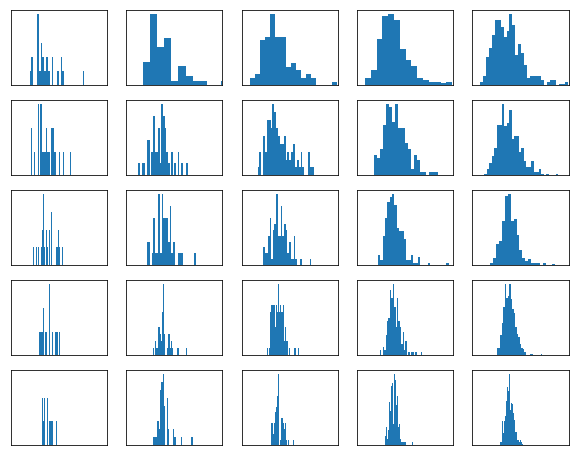

In [16]:
f, axes = plt.subplots(5, 5, sharex=True, figsize=(10, 8))
for i in range(5):
    for j in range(5):
        axes[i, j].hist(sampling_means[sizes[i]][sizes[j]], bins=30)
        axes[i, j].xaxis.set_ticks_position('none')
        axes[i, j].yaxis.set_ticks_position('none')
        axes[i, j].set_xticklabels([])
        axes[i, j].set_yticklabels([])
        axes[i, j].set_xlim(0, 30)

The histograms also confirm our observations about the means and standard deviations of the sampling distributions. As we increase the number of samples (from left to right in the plot), the sampling distribution becomes more and more normal. As we increase the sample size (from top to bottom in the plot), the sampling distribution becomes narrower (standard deviation decreases).

We can also calculate for every sampling distribution the percentage of intervals that do not contain the true population average (11.53):

In [17]:
for sample_size in sizes:
    for samples in sizes:
        print('\n{} samples of size {} each'.format(samples, sample_size))
        outside = len([i for i in intervals[sample_size][samples] if 11.53 < i[0] or 11.53 > i[1]])/samples
        print('{:.1f}% of confidence intervals does not contain the true average'.format(100 * outside))


25 samples of size 25 each
0.0% of confidence intervals does not contain the true average

50 samples of size 25 each
6.0% of confidence intervals does not contain the true average

100 samples of size 25 each
7.0% of confidence intervals does not contain the true average

200 samples of size 25 each
6.5% of confidence intervals does not contain the true average

400 samples of size 25 each
11.5% of confidence intervals does not contain the true average

25 samples of size 50 each
8.0% of confidence intervals does not contain the true average

50 samples of size 50 each
14.0% of confidence intervals does not contain the true average

100 samples of size 50 each
11.0% of confidence intervals does not contain the true average

200 samples of size 50 each
8.0% of confidence intervals does not contain the true average

400 samples of size 50 each
10.5% of confidence intervals does not contain the true average

25 samples of size 100 each
8.0% of confidence intervals does not contain the t

There is still some randomness here, but in general the fractions seems low. Confidence intervals are of course calculated for much higher numbers of samples than we have here.

Note also that instead of using the equation, we could calculate the confidence interval experimentally. We could simply draw n samples of size k, calculate the mean sample statistic for every sample, and then treat the middle 95% of this sampling distribution as the confidence interval.

## Estimating the average search rank

Let's try a different statistic. It will be the rank of the metadata record in the result list, returned when we perform a metadata search using the record's title (without any modifications). Statistically speaking, the main difference from the number of the references is that the new statistic is much more skewed. Typically in the sample we will have a lot of 1s, and rarely an outlier with a high value. To save time iterating through the results list, I truncate the rank at 100. 100 is also returned if there is not title or if the title is empty.

In [18]:
def search_rank_by_title(work):
    if 'title' not in work:
        return 100
    if not work['title']:
        return 100
    title = work['title'][0]
    if not title:
        return 100
    for i, w in enumerate(works.query(title).sort('relevance')):
        if i > 100:
            return 100
        if w['DOI'] == work['DOI']:
            return i+1
    return 100

sample = get_sample_distribution(100, search_rank_by_title)
print('Example sample distribution: ' + ' '.join([str(s) for s in sample]))

for size in [20, 50, 100, 200, 400, 800, 1600]:
    sample = get_sample_distribution(size, search_rank_by_title)
    ci = confidence_interval(sample, cl)
    print('Based on the sample of size {}, we are {}% sure that the population average is in the range {:.4f}-{:.4f} (estimate {:.4f})'.
          format(len(sample), 100 * cl, ci[0], ci[1], mean(sample)))

Example sample distribution: 1 1 1 1 1 1 1 1 1 100 1 1 1 1 100 3 1 1 1 100 2 1 1 100 1 100 1 3 1 63 1 1 11 1 1 100 1 1 1 100 1 100 2 1 1 1 1 2 5 1 1 9 1 1 1 1 1 100 2 1 46 41 1 21 2 2 1 100 1 1 1 1 1 1 1 1 1 100 1 3 1 1 1 1 1 1 100 1 1 74 1 2 1 100 1 1 1 100 8 1
Based on the sample of size 20, we are 95.0% sure that the population average is in the range -3.8893-16.7893 (estimate 6.4500)
Based on the sample of size 50, we are 95.0% sure that the population average is in the range 4.8556-23.3444 (estimate 14.1000)
Based on the sample of size 100, we are 95.0% sure that the population average is in the range 6.2676-17.3124 (estimate 11.7900)
Based on the sample of size 200, we are 95.0% sure that the population average is in the range 12.1098-21.9302 (estimate 17.0200)
Based on the sample of size 400, we are 95.0% sure that the population average is in the range 12.3452-19.0098 (estimate 15.6775)
Based on the sample of size 800, we are 95.0% sure that the population average is in the ran

Lastly, some important things to remember:
  * (Lack of) certainty. Remember that the confidence level < 1. This means, we are never sure that our confidence interval contains the population average. With the confidence level of 95%, if we chose a sample 100 times, just by chance we would get intervals not containing the population average in approximately 5 cases. If for any reason you need to be 100% sure, just process the entire dataset.
  * Randomness. The sample has to be chosen randomly. So no "first 1000 records from the snapshot". Note how different the partial average numbers of references were from the final number, as I was processing the entire dataset.
  * Sample size. We know already that the larger the sample, the better. As a rule of thumb, using sample sizes < 30 makes the estimates, including the interval, pretty unreliable. The reason is that the standard deviation used for all calculations is obtained from the sample, and it becomes unreliable when the size is small. Also, the more skewed the statistic distribution, the larger sample we need. I used rather small sizes in this notebook, but in general I suggest counting in thousands.
  * Generalization. The sample average can be used as an estimate for the population average, but only the population it was drawn from. This means that if we apply any filters before sampling (which is equivalent to sampling from a subset passing the filter), we can reason only about the filtered subset of the data.
  * Averaging. The whole thing only works with averages (and sums). It doesn't work for other aggregate functions. Note that a proportion of records passing a certain filter can be estimated, if we treat it as an average of 0's (doesn't pass) and 1's (passes).
  * Reproducibility. This is more of an engineering concern. In short, all the analyses we do should be reproducible. In the context of sampling it means, at the very least, that we should record the samples obtained from the API.